<h1 style="line-height:2em;">
PANDAPROSUMER EXAMPLE:<br>
INTERNAL COMBUSTION ENGINE COMBINED HEAT AND POWER (ICE CHP) WITH HEAT STORAGE
</h1>

Example prepared by:
--------------------
    Izak Oberčkal Pluško, Marko Keber, Katja Klinar, Tine Seljak*, Andrej Kitanovski

    Faculty of Mechanical Engineering, University of Ljubljana, Slovenia
    
    *Contact: tine.seljak@fs.uni-lj.si

DESCRIPTION:
--------------------
This tutorial describes how to create a single ICE CHP element in *pandaprosumer* and connect it to a heat storage element. The storage is connected to a single consumer. The user can choose the size of the ICE CHP unit, fuel type and altitude at which the ICE CHP unit is installed, while the time-dependent data (chosen cycle, air intake temperature, demand) is read from a an Excel file and stored in a pandas dataframe. The storage size is defined by its capacity.

![network](figures/ice_chp_storage_demand_1.png)

Glossary:
---------
- Network: a configuration of connected energy generators and energy consumers
- Element: a single energy generator or a single energy consumer
- Container: a pandaprosumer data structure that contains data of an individual element; each element must have its container 
- Controller: the logic of an element that defines its behaviour and its limits
- General controller: the first controller in the network that interacts with controllers of all other elements; this controller also manages external data
- Map / mapping: a connection between two elements; contains information about the what is exchanged between the two elements

Network design philosophy:
--------------------------
In pandaprosumer, a system's component is represented by a network element. Each element is assigned a *container* and its own *element controller*. A container is a structure that contains the component's configuration data (static input data), which can include information that will not change in the analysis such as size, etc. The behaviour of an element is governed by its *controller*. Connections between elements are defined by *mappings*, which couple output parameters of one controller to the input parameter of a controller of a connected element. 
The network is managed by a *general controller* called *ConstProfileController*. This controller is connected to all element controllers and manages time-dependent input data from external sources (e.g. Excel file). For each time step it distributes the time-dependent input data to relevant element controllers. 

CREATING A NETWORK:
--------------------

If we are not in the pandaprosumer parent directory, we should add it to the path so that the program knows where to find the necessary functions:

In [47]:
import sys
import os

current_directory = os.getcwd()
parent_directory = os.path.dirname(current_directory)
sys.path.append(parent_directory)

1 - Input data:
---------------

First, let's import libraries required for data management.

In [48]:
import pandas as pd
from pandapower.timeseries.data_sources.frame_data import DFData

Next, we need to define properties of the ICE CHP element (size, fuel type, altitude, name), which are treated as static input data, i.e. characteristics that don't change during an analysis. Size is the nominal maximum electrical power (unit: [kW]), the fuel type is chosen from the JSON file that contains the fuel map located in *library/chp_maps/fuel_maps.json*. We will use natural gas, which in pandaprosumer is denoted by "ng". The altitude is the altitude above sea level (unit: [m]) of the ICE CHP installation. In examples with more than one ICE CHP instance, we can give each one its own name to easily distinguish between them:

In [49]:
size_kw = 1400
name = 'example_chp'
altitude_m = 0
fuel = 'ng'

Because we are using an instance of a simple heat storage, we need only its capacity (unit: [kWh]) to define its size.

In [50]:
q_capacity_kwh = 10000

We define the period of the analysis by setting its start and end, which have the form "YYYY-MM-DD HH:MM:SS". The time resolution is given in [s]. 

In [51]:
start = '2020-01-01 00:00:00'
end = '2020-01-02 00:00:00'
time_resolution_s = 900         # 15 min
frequency = '15min'

Now we import our time-dependent data and transform it into an appropriate DFData object. DFData is a pandaprosumer object that stores all data of an individual element. The DFData object is limited by the duration of the analysis defined above.

In [52]:
time_series_data = pd.read_excel('data/input_chp.xlsx')

dur = pd.date_range(start, end, freq=frequency, tz='utc')
time_series_data.index = dur
time_series_input = DFData(time_series_data)

print(time_series_data.head())

                               time  cycle  t_intake_k  q_demand_kw
2020-01-01 00:00:00+00:00  00:00:00      2         273            0
2020-01-01 00:15:00+00:00  00:15:00      2         273            0
2020-01-01 00:30:00+00:00  00:30:00      2         273            0
2020-01-01 00:45:00+00:00  00:45:00      2         273            0
2020-01-01 01:00:00+00:00  01:00:00      2         273            0


2 - Creating elements of the network:
--------------------------------------

In this example, the network is made up of three elements: an energy source, a storage unit, and an energy consumer. The source is represented by a single ICE CHP element, storage by a simple heat storage element, and the consumer is modelled by a single heat demand element. 

![elements](figures/ice_chp_storage_demand_2.png)

First we define an empty prosumer *container* object. Each element of the network has its own container, which is later filled with data and results.

In [53]:
from pandaprosumer.create import create_empty_prosumer_container

chp_prosumer = create_empty_prosumer_container()

Then we define the period of the analysis using time data for the analysis given above in Section 1.

In [54]:
from pandaprosumer.create import create_period

period = create_period(chp_prosumer, time_resolution_s, start, end, 'utc', 'default')

2.1. General element:

In a pandaprosumer network, the first element is a general controller (*Const Profile controller*). It reads time-dependent input data (*input_params*) and sends it to other elements of the network (*output_params*). The element's data is stored in the *ConstProfileControllerData* class. The controller (*ConstProfileController*) for this element is created with the  *create_controlled_const_profile* function. At this point, we pass to the general controller element the previously created prosumer container, titles of data columns (*input_params*) in the input file (Excel file, in this case) and the coresponding names of output columns (*output_params*), the period of the analysis and the time-dependent data in the DFData object.

In [55]:
from pandaprosumer.create_controlled import create_controlled_const_profile

input_columns = ['q_demand_kw', 'cycle', 't_intake_k']
result_columns = ['q_demand_cp_kw', 'cycle_cp', 't_intake_cp_k']

cp_index = create_controlled_const_profile(
    chp_prosumer, input_columns, result_columns, period, time_series_input)

2.2. ICE CHP element:

We define the ICE CHP element to which we pass the prosumer container and the data that defines the ICE CHP instance, i.e. size, fuel type, altitude, and its name.

In [56]:
from pandaprosumer.create_controlled import create_controlled_ice_chp
ice_chp_index = create_controlled_ice_chp(chp_prosumer, size_kw, fuel, altitude_m, name,level=1,order=0)

2.3. Simple heat storage element:

Here we create second element in the network that represents heat storage.

In [57]:
from pandaprosumer.create_controlled import create_controlled_heat_storage

heat_storage_index = create_controlled_heat_storage(chp_prosumer, q_capacity_kwh,level = 1,order=1)


2.4. Heat demand element:

Finally, we create the consumer, which is simulated with the heat demand element. We pass the prosumer container to it. The auxiliary scaling parameter allows us to easily adjust the demanded heat by simply scaling it.

In [58]:
from pandaprosumer.create_controlled import create_controlled_heat_demand

heat_demand_index = create_controlled_heat_demand(chp_prosumer, scaling=1.0,level=1,order=2)

3 - Creating connections (mappings) between controllers:
---------------------------------------------------------

![controllers](figures/ice_chp_storage_demand_3.png)

For each controller we define how it is connected to other controllers. In this case we use *Generic Mapping*. The main parameter for the map is the flow of thermal energy (*p_th_out_kw*): the output energy flow of one element is linked with the input energy flow of the connected element. 

In [59]:
from pandaprosumer.mapping import GenericMapping

3.1. Connection GENERAL CONTROLLER ---> ICE CHP:

The general controller (*initiator_column*) instructs the ICE CHP controller (*responder_column*) what value to use for *cycle* and *t_intake_k*. 

In [60]:
GenericMapping(
    chp_prosumer,
    initiator_id=cp_index,
    initiator_column="cycle_cp",
    responder_id=ice_chp_index,
    responder_column="cycle",
);
GenericMapping(
    chp_prosumer,
    initiator_id=cp_index,
    initiator_column="t_intake_cp_k",
    responder_id=ice_chp_index,
    responder_column="t_intake_k",
);

3.2. Connection ICE CHP ---> SIMPLE HEAT STORAGE:

The ICE CHP controller (*initiator_column*) informs the heat storage controller (*responder_column*) of how much thermal power (*p_th_out_kw*) it can supply at each time step. 

In [61]:
GenericMapping(
    chp_prosumer,
    initiator_id=ice_chp_index,
    initiator_column="p_th_out_kw",
    responder_id=heat_storage_index,
    responder_column="q_received_kw",
);

3.3. Connection SIMPLE HEAT STORAGE ---> HEAT DEMAND (consumer):

Heat demand controller instructs the heat storage controller how much heat to supply.

In [62]:
GenericMapping(
    chp_prosumer,
    initiator_id=heat_storage_index,
    initiator_column="q_delivered_kw",
    responder_id=heat_demand_index,
    responder_column="q_received_kw",
);

3.4. Connection GENERAL CONTROLLER ---> HEAT DEMAND (consumer):

The general controller sends the demand controller information about the actual demand at each time step.

In [63]:
GenericMapping(
    chp_prosumer,                                                  
    initiator_id=cp_index,                                               
    initiator_column="q_demand_cp_kw",
    responder_id=heat_demand_index,                                                
    responder_column="q_demand_kw",
);

RUNNING THE ANALYSIS:
-----------------------

We can now run the analysis with the input data defined above. 

In [64]:
from pandaprosumer.run_time_series import run_timeseries

run_timeseries(chp_prosumer, period, True);


100%|██████████| 97/97 [00:01<00:00, 75.55it/s]


PRINTING AND PLOTTING RESULTS:
----------------------------------

First, we plot the evolution of the demand from the Excel file.

In [65]:
import matplotlib.pyplot as plt

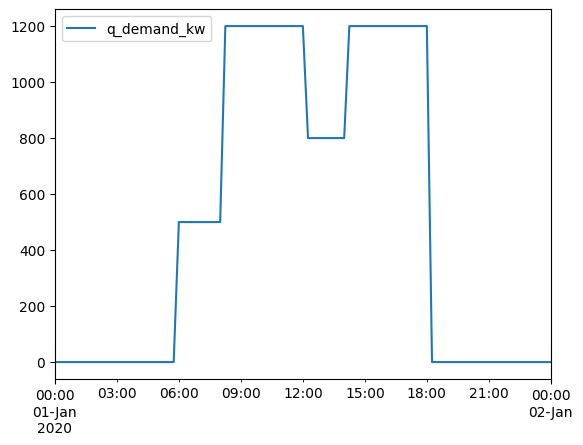

In [66]:
time_series_data.plot(y='q_demand_kw');
plt.show()

In [67]:
print(chp_prosumer.heat_demand)

   name  scaling  in_service
0  None      1.0        True


We then list the available results for the ICE CHP element. Results are stored in the form of time series, which can be plotted on a graph. The *.time_series* command lists all input and output dataframes. 

In [68]:
print(chp_prosumer.time_series)

   name       element  element_index  period_index data_source
0  True       ice_chp            0.0           0.0      DFData
1  None  heat_storage            0.0           0.0      DFData
2  None   heat_demand            0.0           0.0      DFData


Here *.data_source* lists all available dataframes that we then specify with the *index* key in *.loc[]*.

In [69]:
print(chp_prosumer.time_series.data_source)

0    DFData
1    DFData
2    DFData
Name: data_source, dtype: object


Before plotting we have to look at the resulting dataframe to see which quantity (column) we would like to plot. The *index* key can be an integer or the name of a specific component we want to look at. 

In [70]:
print(chp_prosumer.time_series.data_source.loc[0].df.head())

                            load  p_in_kw  p_el_out_kw  p_th_out_kw  \
2020-01-01 00:00:00+00:00  100.0   3500.0       1400.0      1223.11   
2020-01-01 00:15:00+00:00  100.0   3500.0       1400.0      1223.11   
2020-01-01 00:30:00+00:00  100.0   3500.0       1400.0      1223.11   
2020-01-01 00:45:00+00:00  100.0   3500.0       1400.0      1223.11   
2020-01-01 01:00:00+00:00  100.0   3500.0       1400.0      1223.11   

                           p_rad_out_kw  ice_chp_efficiency  \
2020-01-01 00:00:00+00:00        218.56              74.946   
2020-01-01 00:15:00+00:00        218.56              74.946   
2020-01-01 00:30:00+00:00        218.56              74.946   
2020-01-01 00:45:00+00:00        218.56              74.946   
2020-01-01 01:00:00+00:00        218.56              74.946   

                           mdot_fuel_in_kg_per_s  acc_m_fuel_in_kg  \
2020-01-01 00:00:00+00:00               0.068466         61.619718   
2020-01-01 00:15:00+00:00               0.068466      

Now we can plot the evolution of the heat that the ICE CHP generates based on the demand. 

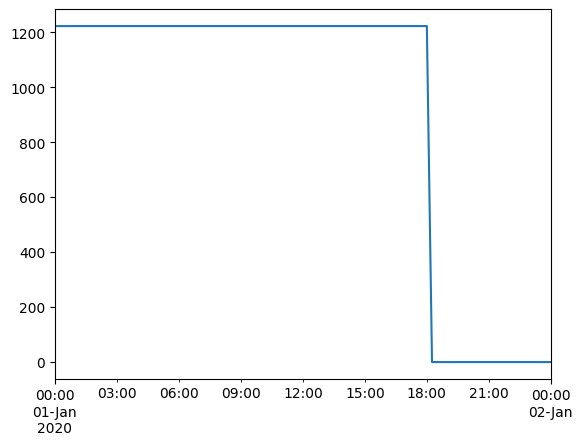

In [71]:
chp_prosumer.time_series.data_source.loc[0].df.p_th_out_kw.plot()
plt.show()

We can also plot time evolution of state of charge (SOC) of the heat storage element.

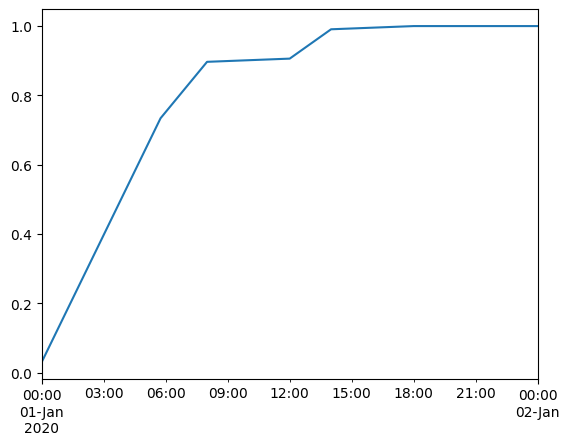

In [72]:
chp_prosumer.time_series.data_source.loc[1].df.soc.plot()
plt.show()

ACKNOWLEDGEMENTS:
-----------------
The authors would like to thank Pratikshya Mohanty and Odile Capron from the Fraunhofer Institute for the help in preparing this tutorial. Special thanks also to Pawel Lytaev and colleagues from the University of Kassel for their code reviews and suggestions during the development of the models. Support from the Senergy Nets project, funded by the European Union under the Horizon Europe program (Grant Agreement No. 101075731) is gratefully acknowledged.